# exp001_m_stage1
昨年のコードを再現

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from tqdm import tqdm
from itertools import product

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from optuna.integration import lightgbm as lgb_tuner
from catboost import CatBoost, FeaturesData, Pool

from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
# 設定
EXP_NAME = 'exp001_m_stage1'
INPUT_DIR = '../input/ncaam-march-mania-2021'
OUTPUT_DIR = f'../output/{EXP_NAME}'

In [3]:
# 出力フォルダ生成
os.makedirs(OUTPUT_DIR)

## データ読み込み

In [4]:
tourny_results = pd.read_csv(INPUT_DIR + '/MNCAATourneyDetailedResults.csv')
regular_results = pd.read_csv(INPUT_DIR + '/MRegularSeasonDetailedResults.csv')
seeds = pd.read_csv(INPUT_DIR + '/MNCAATourneySeeds.csv')
conf = pd.read_csv(INPUT_DIR + '/MTeamConferences.csv')
massey = pd.read_csv(INPUT_DIR + '/MMasseyOrdinals.csv')
kenpom = pd.read_csv(INPUT_DIR + '/NCAA2021_Kenpom.csv')

In [5]:
test = pd.read_csv(INPUT_DIR + '/MSampleSubmissionStage1.csv')

## 特徴量生成

In [6]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    output['win'] = 1
    output.loc[output['T1_Score'] < output['T2_Score'],'win'] = 0
    
    #stats
    output['T1_Posses'] = 0.96*(output['T1_FGA']+output['T1_TO']+(0.475*output['T1_FTA']))-output['T1_OR']
    output['T1_Offens_Rate'] = 100*(output['T1_Score']/output['T1_Posses'])
    output['T1_Defens_Rate'] = 100*(output['T2_Score']/output['T1_Posses'])
    output['T1_Str_Schedule'] = 100*(output['T1_Offens_Rate']-output['T1_Defens_Rate'])
    output['T1_PIE'] = (output['T1_Score']+output['T1_FGM']+output['T1_FTM']-output['T1_FGA']-output['T1_FTA']+output['T1_DR']
                        +(0.5*output['T1_OR'])+output['T1_Ast']+output['T1_Stl']+(0.5*output['T1_Blk'])-output['T1_PF']-output['T1_TO'])
    output['T2_PIE'] = (output['T2_Score']+output['T2_FGM']+output['T2_FTM']-output['T2_FGA']-output['T2_FTA']+output['T2_DR']
                        +(0.5*output['T2_OR'])+output['T2_Ast']+output['T2_Stl']+(0.5*output['T2_Blk'])-output['T2_PF']-output['T2_TO'])
    
    output['T1_TIE'] = output['T1_PIE']/(output['T1_PIE']+output['T2_PIE'])
    output['T1_Ast_Rate'] = (100*output['T1_Ast'])/(output['T1_FGA']+(0.475*output['T1_FTA'])+output['T1_Ast']+output['T1_TO'])
    output['T1_TO_Rate'] = (100*output['T1_TO'])/(output['T1_FGA']+(0.475*output['T1_FTA'])+output['T1_Ast']+output['T1_TO'])
    output['T1_True_Shoot%'] = (100*output['T1_Score'])/(2*(output['T1_FGA']+(0.475+output['T1_FTA'])))
    output['T1_Effect_FG%'] = (output['T1_FGM']+0.5*output['T1_FGM3'])/output['T1_FGA']
    output['T1_Free_Rate'] = output['T1_FTA']/output['T1_FGA']
    output['T1_OR%'] = output['T1_OR']/(output['T1_OR']+output['T2_OR'])
    output['T1_DR%'] = output['T1_DR']/(output['T1_DR']+output['T2_DR'])
    output['T1_TR%'] = (output['T1_DR']+output['T1_OR'])/(output['T1_DR']+output['T1_OR']+output['T2_DR']+output['T2_OR']) 
    
    return output

In [7]:
def agg_data(df, label):
    key = ['Season', 'T1_TeamID']
    res = df[key].drop_duplicates()


    # 試合数
    tmp = df.groupby(key)['DayNum'].count().reset_index()
    tmp = tmp.rename(columns = {'DayNum':'total_game_cnt'})
    res = res.merge(tmp, on=key, how='left')

    # 平均値
    cols = list(df.columns)
    cols = [c for c in cols if c not in ['DayNum','location','T2_TeamID', 'win']]
    tmp = df[cols].groupby(key).mean().reset_index()
    tmp.columns = [c if c in key else c + '_mean_' + label  for c in cols]
    res = res.merge(tmp, on=key, how='left')

    # 勝率
    # 全体
    tmp = df.groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_' + label})
    res = res.merge(tmp, on=key, how='left')
    # アウェイ
    tmp = df.loc[df['location']==-1].groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_a_' + label})
    res = res.merge(tmp, on=key, how='left')
    # ホーム
    tmp = df.loc[df['location']==1].groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_h_' + label})
    res = res.merge(tmp, on=key, how='left')

    res.columns = res.columns.str.replace('T1_', '')
    res.columns = res.columns.str.replace('T2_', 'Op_')
    
    return res

In [8]:
tourny_data = prepare_data(tourny_results)
regular_data = prepare_data(regular_results)

tourny_summary = agg_data(tourny_data, 'TOUR')
regular_summary = agg_data(regular_data, 'REG')

In [9]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [10]:
conf['isMeasure'] = 0
measure_confs = ['a_ten','aac','acc','big_east','big_ten','big_twelve',
                 'mwc','wcc','pac_ten','pac_twelve','sec']

for mc in measure_confs:
    conf.loc[conf['ConfAbbrev']==mc,'isMeasure'] = 1

In [11]:
regular_tour = pd.concat([tourny_data[['Season','T1_TeamID','T2_TeamID','win']],regular_data[['Season','T1_TeamID','T2_TeamID','win']]])
overall_history = pd.DataFrame()

for s in regular_tour['Season'].unique():
    tmp = regular_tour[regular_tour['Season']!=s]
    tmp = tmp.groupby(['T1_TeamID','T2_TeamID'])['win'].mean().reset_index()
    tmp['Season'] = s
    tmp = tmp.rename(columns={'win':'win_rate_overall'})
    overall_history = overall_history.append(tmp)

In [12]:
last14d = regular_data[regular_data['DayNum']>118]
last14d = last14d.groupby(['Season','T1_TeamID'])['win'].mean().reset_index()
last14d = last14d.rename(columns={'win':'l14d_win_rate','T1_TeamID':'TeamID'})

In [13]:
massey_agg = massey[massey['RankingDayNum']==133].groupby(['Season','TeamID'])['OrdinalRank'].mean().reset_index()

In [14]:
kenpom = kenpom[['Season', 'TeamID', 'rank', 'adj_em', 'adj_o', 'adj_o_rank',
       'adj_d', 'adj_d_rank', 'adj_tempo', 'adj_tempo_rank', 'luck',
       'luck_rank', 'sos_adj_em', 'sos_adj_em_rank', 'sos_adj_o',
       'sos_adj_o_rank', 'sos_adj_d', 'sos_adj_d_rank', 'nc_sos_adj_em',
       'nc_sos_adj_em_rank']]

kenpom.columns = ['Season', 'TeamID', 'kenpom_rank', 'kenpom_adj_em', 'kenpom_adj_o', 'kenpom_adj_o_rank',
       'kenpom_adj_d', 'kenpom_adj_d_rank', 'kenpom_adj_tempo', 'kenpom_adj_tempo_rank', 'kenpom_luck',
       'kenpom_luck_rank', 'kenpom_sos_adj_em', 'kenpom_sos_adj_em_rank', 'kenpom_sos_adj_o',
       'kenpom_sos_adj_o_rank', 'kenpom_sos_adj_d', 'kenpom_sos_adj_d_rank', 'kenpom_nc_sos_adj_em',
       'kenpom_nc_sos_adj_em_rank']

## train,test生成

In [15]:
def merge_data(df,merge_df,col):
    df = df.merge(merge_df[['Season','TeamID', col]],left_on=['Season','T1_TeamID'],right_on=['Season','TeamID'],how='left')
    df = df.rename(columns={col:'T1_' + col})
    del df['TeamID']

    df = df.merge(merge_df[['Season','TeamID', col]],left_on=['Season','T2_TeamID'],right_on=['Season','TeamID'],how='left')
    df = df.rename(columns={col:'T2_' + col})
    del df['TeamID']
    
    return df

In [16]:
def process_train_test_data(df):
    df = merge_data(df, seeds, 'Seed')
    df['Seed_dif'] = df['T1_Seed'] - df['T2_Seed']
    
    df = merge_data(df, conf, 'isMeasure')
    
    items = ['Score_mean_REG','Op_Score_mean_REG','PointDiff_mean_REG',
             'win_rate_REG', 'win_rate_a_REG','win_rate_h_REG',
             'Posses_mean_REG', 'Offens_Rate_mean_REG',
             'Defens_Rate_mean_REG', 'Str_Schedule_mean_REG', 'PIE_mean_REG',
             'Op_PIE_mean_REG', 'TIE_mean_REG', 'Ast_Rate_mean_REG',
             'TO_Rate_mean_REG', 'True_Shoot%_mean_REG', 'Effect_FG%_mean_REG',
             'Free_Rate_mean_REG', 'OR%_mean_REG', 'DR%_mean_REG', 'TR%_mean_REG']
    for item in items:
        df = merge_data(df, regular_summary, item)
        df[item + '_dif'] = df['T1_' + item] - df['T2_' + item]
        del df['T1_' + item]
        del df['T2_' + item]
        
    df = df.merge(overall_history,on=['T1_TeamID','T2_TeamID','Season'],how='left')
    df['win_rate_overall'] = df['win_rate_overall'].fillna(-1)
    df = merge_data(df, last14d, 'l14d_win_rate')
    df['l14d_win_rate_dif'] = df['T1_l14d_win_rate'] - df['T2_l14d_win_rate']
    del df['T1_l14d_win_rate']
    del df['T2_l14d_win_rate']
    
    df = merge_data(df, massey_agg, 'OrdinalRank')
    df['OrdinalRank_dif'] = df['T1_OrdinalRank'] - df['T2_OrdinalRank']
    del df['T1_OrdinalRank']
    del df['T2_OrdinalRank']
    
    items = ['kenpom_rank', 'kenpom_adj_em', 'kenpom_adj_o', 'kenpom_adj_o_rank',
   'kenpom_adj_d', 'kenpom_adj_d_rank', 'kenpom_adj_tempo', 'kenpom_adj_tempo_rank', 'kenpom_luck',
   'kenpom_luck_rank', 'kenpom_sos_adj_em', 'kenpom_sos_adj_em_rank', 'kenpom_sos_adj_o',
   'kenpom_sos_adj_o_rank', 'kenpom_sos_adj_d', 'kenpom_sos_adj_d_rank', 'kenpom_nc_sos_adj_em',
   'kenpom_nc_sos_adj_em_rank']
    
    for item in items:
        df = merge_data(df, kenpom, item)
        df[item + '_dif'] = df['T1_' + item] - df['T2_' + item]
        del df['T1_' + item]
        del df['T2_' + item]
    
    return df

In [17]:
train = tourny_data[['Season','T1_TeamID', 'T2_TeamID', 'win']].copy()
train = train[train['T1_TeamID']<train['T2_TeamID']]
train = process_train_test_data(train)

In [18]:
features = [c for c in train.columns if c not in ['Season','win','T1_TeamID','T2_TeamID','T1_Seed','T2_Seed']]
target = 'win'

In [19]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['T1_TeamID'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['T2_TeamID'] = test['ID'].apply(lambda x: int(x.split('_')[2]))

test = process_train_test_data(test)

In [20]:
sc = StandardScaler()
train[features] = sc.fit_transform(train[features])
test[features] = sc.transform(test[features])

## 学習

In [21]:
def show_eval_results(df):
    eval_summary = pd.DataFrame()
    means = []
    for eval_s in eval_seasons:
        df_s = df[df['Season']==eval_s]
        res = log_loss(df_s[target], df_s['pred'])
        eval_summary.loc[0,'s'+str(eval_s)] = res

    total = log_loss(df[target], df['pred'])
    eval_summary.loc[0,'total'] = total
    print(eval_summary)

In [22]:
def fit_eval(cols):
    eval_seasons = np.arange(2015,2020,1)
    eval_df_all = pd.DataFrame()
    #feature_importances = pd.DataFrame()
    #feature_importances['feature'] = features

    for eval_s in eval_seasons:
        eval_df = train[train['Season'] == eval_s].copy()
        train_df = train[train['Season'] != eval_s].copy()

        model = LogisticRegression(max_iter=1000)
        model.fit(train_df[cols],train_df[target])

        eval_df['pred'] = model.predict_proba(eval_df[cols])[:,1]
        res = log_loss(eval_df[target], eval_df['pred'])
        eval_df_all = eval_df_all.append(eval_df)

    total = log_loss(eval_df_all[target], eval_df_all['pred'])
    
    return total

In [23]:
# stepwiseでの変数選択
select_features = features.copy()
start_score = fit_eval(features)
start_col_num = len(features)

for i in range(len(features)):
    best_score = fit_eval(select_features)
    print('itr' + str(i+1) + ' / num:' + str(len(select_features)) + ' / st_score:' + str(best_score))
    drop_col = 'None'
    for c in select_features:
        tmp_features = select_features.copy()
        tmp_features.remove(c)
        res = fit_eval(tmp_features)
        print(f'DROP:{c} / {res}')
        if res < best_score:
            best_score = res
            drop_col = c
    if drop_col == 'None' : 
        break
    else:
        print(f'BEST_RESULT : {best_score} / DROP_COL : {drop_col}')
        select_features.remove(drop_col)
print('★☆'*20)
print('[STEPWISE_RESULT]')
print(f'col_num : {str(start_col_num)} → {str(len(select_features))}')
print(f'score : {str(start_score)} → {str(best_score)}')
print('\n[select_features]')
for c in select_features:
    print(c)

itr1 / num:45 / st_score:0.44982678110699387
DROP:Seed_dif / 0.4565200535303507
DROP:T1_isMeasure / 0.4537188722817006
DROP:T2_isMeasure / 0.4486053753723292
DROP:Score_mean_REG_dif / 0.44980246075187413
DROP:Op_Score_mean_REG_dif / 0.4490105377657518
DROP:PointDiff_mean_REG_dif / 0.4492823374798918
DROP:win_rate_REG_dif / 0.45010508451011233
DROP:win_rate_a_REG_dif / 0.4486995080788066
DROP:win_rate_h_REG_dif / 0.4489359365128143
DROP:Posses_mean_REG_dif / 0.4495833940767333
DROP:Offens_Rate_mean_REG_dif / 0.4496755068277417
DROP:Defens_Rate_mean_REG_dif / 0.44982283855579064
DROP:Str_Schedule_mean_REG_dif / 0.4497923303601649
DROP:PIE_mean_REG_dif / 0.44972548819293096
DROP:Op_PIE_mean_REG_dif / 0.451532214880265
DROP:TIE_mean_REG_dif / 0.4493748628854401
DROP:Ast_Rate_mean_REG_dif / 0.4503522358821313
DROP:TO_Rate_mean_REG_dif / 0.4494796260487482
DROP:True_Shoot%_mean_REG_dif / 0.4496849303504895
DROP:Effect_FG%_mean_REG_dif / 0.44789858260445736
DROP:Free_Rate_mean_REG_dif / 0.457

In [24]:
eval_seasons = np.arange(2015,2020,1)
eval_df_all = pd.DataFrame()
#feature_importances = pd.DataFrame()
#feature_importances['feature'] = features

for eval_s in eval_seasons:
    eval_df = train[train['Season'] == eval_s].copy()
    train_df = train[train['Season'] != eval_s].copy()

    model = LogisticRegression()
    model.fit(train_df[select_features],train_df[target])
    
    eval_df['pred'] = model.predict_proba(eval_df[select_features])[:,1]
    res = log_loss(eval_df[target], eval_df['pred'])
    print(f'[SEASON:{str(eval_s)}]')
    print(f'logloss = {res}')
    eval_df_all = eval_df_all.append(eval_df)
    
total = log_loss(eval_df_all[target], eval_df_all['pred'])

print('[total]')
print(f'logloss = {total}')

[SEASON:2015]
logloss = 0.4001052325013008
[SEASON:2016]
logloss = 0.5018646573944013
[SEASON:2017]
logloss = 0.4727271314385811
[SEASON:2018]
logloss = 0.4113094553518226
[SEASON:2019]
logloss = 0.285011125350033
[total]
logloss = 0.4142035204072278


<AxesSubplot:>

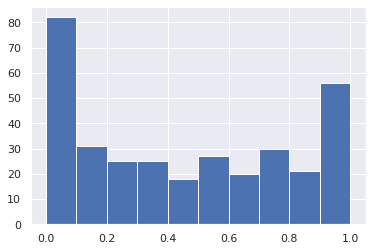

In [25]:
eval_df_all['pred'].hist()

In [26]:
show_eval_results(eval_df_all)

      s2015     s2016     s2017     s2018     s2019     total
0  0.400105  0.501865  0.472727  0.411309  0.285011  0.414204


In [27]:
for th in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
    tmp = eval_df_all.copy()
    tmp['pred'] = np.clip(tmp['pred'],th,1-th)
    print('th:'+str(th))
    show_eval_results(tmp)
    print()

th:0.01
      s2015     s2016     s2017     s2018     s2019     total
0  0.401154  0.424087  0.403352  0.411641  0.285906  0.385228

th:0.02
      s2015     s2016     s2017     s2018     s2019     total
0  0.402697  0.415312  0.394658  0.408983  0.287663  0.381863

th:0.03
     s2015     s2016     s2017     s2018     s2019     total
0  0.40452  0.410974  0.390722  0.404146  0.289797  0.380032

th:0.04
     s2015     s2016     s2017    s2018     s2019     total
0  0.40726  0.408536  0.388936  0.40142  0.292406  0.379712

th:0.05
     s2015     s2016     s2017     s2018     s2019     total
0  0.41073  0.407155  0.388581  0.400136  0.295142  0.380349

th:0.06
     s2015     s2016     s2017     s2018     s2019     total
0  0.41326  0.406487  0.389286  0.399941  0.298087  0.381412

th:0.07
      s2015     s2016     s2017    s2018     s2019     total
0  0.414252  0.406394  0.390657  0.40054  0.301275  0.382623

th:0.08
      s2015    s2016     s2017     s2018     s2019    total
0  0.414302  

## make_sub

In [28]:
th = 0.04

In [29]:
submission = test[['ID', 'Pred']].copy()
pred = np.zeros(test.shape[0])

model = LogisticRegression()
model.fit(train[select_features],train[target])
pred = model.predict_proba(test[select_features])[:,1]
pred = np.clip(pred,th,1-th)
test['Pred'] = pred
submission['Pred'] = pred

In [30]:
tmp = test.merge(tourny_data[['Season','T1_TeamID', 'T2_TeamID','win']], on=['Season','T1_TeamID', 'T2_TeamID'],how='inner')
log_loss(tmp[target], tmp['Pred'])

0.36778122133408375

<AxesSubplot:>

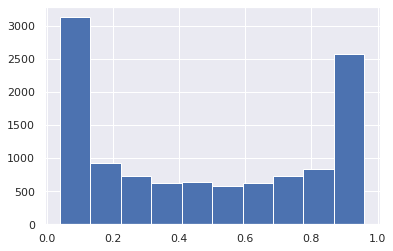

In [31]:
submission['Pred'].hist()

In [32]:
submission.to_csv(OUTPUT_DIR + '/submission.csv', index=False)

In [37]:
test

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Seed,T2_Seed,Seed_dif,T1_isMeasure,T2_isMeasure,...,kenpom_luck_dif,kenpom_luck_rank_dif,kenpom_sos_adj_em_dif,kenpom_sos_adj_em_rank_dif,kenpom_sos_adj_o_dif,kenpom_sos_adj_o_rank_dif,kenpom_sos_adj_d_dif,kenpom_sos_adj_d_rank_dif,kenpom_nc_sos_adj_em_dif,kenpom_nc_sos_adj_em_rank_dif
0,2015_1107_1112,0.040000,2015,1107,1112,14,2,1.576817,-1.633329,0.587362,...,1.465332,-1.685597,-1.607419,2.079092,-1.821778,2.386974,1.279286,1.464125,0.010046,-0.041183
1,2015_1107_1116,0.077641,2015,1107,1116,14,5,1.174524,-1.633329,0.587362,...,0.189005,-0.171554,-1.443456,1.919285,-1.561111,2.106854,1.227023,1.381275,0.586455,-0.868830
2,2015_1107_1124,0.072298,2015,1107,1124,14,3,1.442719,-1.633329,0.587362,...,1.498058,-1.766997,-1.972495,2.348241,-1.963960,2.522789,1.854175,1.820380,0.108019,-0.158303
3,2015_1107_1125,0.462215,2015,1107,1125,14,15,-0.166449,-1.633329,-1.702528,...,-0.138258,0.080787,-0.236786,0.565130,-0.423655,0.587418,0.024983,0.030822,0.299067,-0.447198
4,2015_1107_1129,0.161298,2015,1107,1129,14,11,0.369940,-1.633329,0.587362,...,0.778079,-0.928575,-0.783758,1.439863,-0.992383,1.724873,0.495347,0.768186,0.075362,-0.111455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.256146,2019,1449,1459,9,7,0.235843,0.612247,-1.702528,...,0.728990,-0.489014,0.584314,-0.343248,0.429436,-0.227476,-0.732825,-0.689973,-0.925597,0.661537
11386,2019_1449_1463,0.859085,2019,1449,1463,9,14,-0.702839,0.612247,-1.702528,...,0.810805,-0.586695,0.958356,-0.932011,1.140346,-1.424350,-0.732825,-0.656833,0.782401,-1.024990
11387,2019_1458_1459,0.350802,2019,1458,1459,5,7,-0.300546,0.612247,-1.702528,...,-1.005505,1.261090,1.469461,-0.805847,1.069255,-0.634923,-1.830340,-1.170502,-0.858648,0.614689
11388,2019_1458_1463,0.905363,2019,1458,1463,5,14,-1.239228,0.612247,-1.702528,...,-0.923689,1.163409,1.843503,-1.394611,1.780164,-1.831797,-1.830340,-1.137362,0.849349,-1.071838


In [36]:
train

,Season,T1_TeamID,T2_TeamID,win,T1_Seed,T2_Seed,Seed_dif,T1_isMeasure,T2_isMeasure,Score_mean_REG_dif,...,kenpom_luck_dif,kenpom_luck_rank_dif,kenpom_sos_adj_em_dif,kenpom_sos_adj_em_rank_dif,kenpom_sos_adj_o_dif,kenpom_sos_adj_o_rank_dif,kenpom_sos_adj_d_dif,kenpom_sos_adj_d_rank_dif,kenpom_nc_sos_adj_em_dif,kenpom_nc_sos_adj_em_rank_dif
0,2003,1112,1436,1,1,16,-2.043812,0.612247,-1.702528,2.316866,...,-0.383705,0.463368,1.812760,-1.890854,1.922346,-2.044009,-1.569027,-1.626177,1.706614,-1.477854
1,2003,1113,1272,1,10,7,0.369940,0.612247,-1.702528,0.118891,...,-0.269163,0.365688,0.542042,-0.494644,0.761194,-0.830157,-0.262462,-0.259153,0.338256,-0.259807
2,2003,1141,1166,1,11,6,0.638135,-1.633329,-1.702528,-0.066310,...,1.858047,-0.822755,0.329401,-0.318015,0.476830,-0.533061,-0.131805,-0.159733,0.545632,-0.603358
3,2003,1143,1301,1,8,9,-0.166449,0.612247,0.587362,0.206200,...,1.416242,-1.514657,-0.140713,0.152995,0.002890,0.027178,0.286296,0.221376,1.102446,-1.149918
4,2003,1228,1443,1,4,13,-1.239228,0.612247,-1.702528,0.241125,...,-1.005505,1.293650,0.835383,-0.763793,0.690103,-0.753761,-0.941876,-0.723113,-1.028468,1.153440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,1345,1438,0,3,1,0.235843,0.612247,0.587362,0.517327,...,-1.021868,1.277370,0.294815,-0.191852,0.310951,-0.227476,-0.288593,-0.118308,1.192255,-1.579357
1111,2019,1181,1277,0,1,2,-0.166449,0.612247,0.587362,0.563112,...,0.319911,-0.391334,-0.063855,0.001599,0.073981,-0.074683,0.207902,0.055677,0.295801,-0.345695
1112,2019,1277,1403,0,2,3,-0.166449,0.612247,0.587362,0.708054,...,-0.007352,0.007527,0.360144,-0.200262,0.239860,-0.151080,-0.497643,-0.201158,1.404530,-1.774557
1113,2019,1120,1438,0,5,1,0.504038,0.612247,0.587362,0.888156,...,-0.645515,0.772688,0.175685,-0.132975,0.405739,-0.312361,0.077246,0.022537,0.953854,-1.259230
